In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
from scipy import stats
from scipy.special import boxcox, inv_boxcox

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, classification_report, precision_score, recall_score 
from sklearn.metrics import confusion_matrix, precision_recall_curve, roc_curve, auc, log_loss
%matplotlib inline
import matplotlib.pyplot as plt  # Matlab-style plotting
import seaborn as sns
color = sns.color_palette()
sns.set_style('darkgrid')
import warnings
def ignore_warn(*args, **kwargs):
    pass
warnings.warn = ignore_warn #ignore annoying warning (from sklearn and seaborn)
import matplotlib.style as style
import seaborn as sns

In [ ]:
train = pd.read_csv('/content/drive/MyDrive/HAcker/train.csv')
test = pd.read_csv('/content/drive/MyDrive/HAcker/test.csv')


In [ ]:
train.head()

,Property_ID,Property_Type,Property_Area,Number_of_Windows,Number_of_Doors,Furnishing,Frequency_of_Powercuts,Power_Backup,Water_Supply,Traffic_Density_Score,Crime_Rate,Dust_and_Noise,Air_Quality_Index,Neighborhood_Review,Habitability_score
0,0x21e3,Apartment,106,NaN,1,Semi_Furnished,0.0,No,Once in a day - Morning,5.89,Slightly below average,Medium,90.0,3.86,71.98
1,0x68d4,Apartment,733,2.0,2,Unfurnished,1.0,No,Once in a day - Evening,4.37,Well below average,Medium,96.0,3.55,71.20
2,0x7d81,Apartment,737,4.0,2,Fully Furnished,0.0,No,Once in a day - Morning,7.45,Slightly below average,Medium,121.0,3.81,71.39
3,0x7a57,Apartment,900,3.0,2,Unfurnished,2.0,Yes,Once in a day - Morning,6.16,Well above average,Medium,100.0,1.34,31.46
4,0x9409,Bungalow,2238,14.0,6,Fully Furnished,0.0,No,All time,5.46,Well below average,Medium,116.0,4.77,93.70


In [ ]:
train.shape, test.shape

((39499, 15), (10500, 14))

In [ ]:
train.drop(['Property_ID'], axis=1, inplace=True)
test.drop(['Property_ID'], axis=1, inplace=True)

In [ ]:
train_features = train.drop(['Habitability_score'], axis=1)
test_features = test
features = pd.concat([train_features, test_features]).reset_index(drop=True)

In [ ]:
features.loc[features['Water_Supply'] == 'NOT MENTIONED','Water_Supply'] = np.nan
features.loc[features['Power_Backup'] == 'NOT MENTIONED','Power_Backup'] = np.nan
features.head(30)
features.loc[features['Property_Type'] == '#R%$G&867','Property_Type'] = np.nan

In [ ]:
k=features
categorical_features = k.dtypes[k.dtypes == "object"].index
numerical_features = k.dtypes[k.dtypes != "object"].index

In [ ]:
to_encode = [feat for feat in categorical_features if features[feat].dtype=='object']

In [ ]:
to_encode

['Property_Type',
 'Furnishing',
 'Power_Backup',
 'Water_Supply',
 'Crime_Rate',
 'Dust_and_Noise']

In [ ]:
!pip install impyute

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from impyute.imputation.cs import mice
from sklearn.preprocessing import OrdinalEncoder

In [ ]:
ode = OrdinalEncoder(dtype = int)

In [ ]:
def encode(data):
    '''function to encode non-nan data and replace it in the original data'''
    #retains only non-null values
    nonulls = np.array(data.dropna())
    #reshapes the data for encoding
    impute_reshape = nonulls.reshape(-1,1)
    #encode date
    impute_ordinal = ode.fit_transform(impute_reshape)
    #Assign back encoded values to non-null values
    data.loc[data.notnull()] = np.squeeze(impute_ordinal)
    return data

#create a for loop to iterate through each column in the data
for columns in to_encode:
    encode(features[columns])

In [ ]:
features.loc[:, categorical_features].head(10)

,Property_Type,Furnishing,Power_Backup,Water_Supply,Crime_Rate,Dust_and_Noise
0,0,1,0,2,1,2
1,0,2,0,1,3,2
2,0,0,0,2,1,2
3,0,2,1,2,2,2
4,1,0,0,0,3,2
5,4,2,0,2,3,2
6,4,1,0,1,NaN,2
7,3,1,0,0,2,2
8,0,1,0,0,3,NaN
9,0,1,1,2,3,2


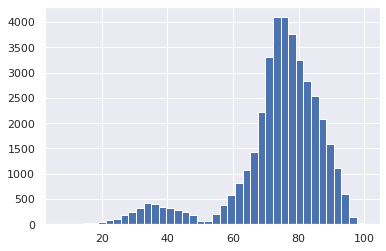

In [ ]:
train['Habitability_score'].hist(bins = 40)

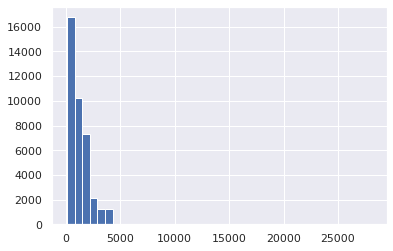

In [ ]:
train['Property_Area'].hist(bins = 40)



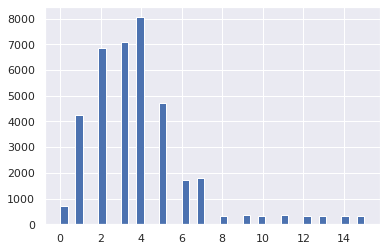

In [ ]:
train['Number_of_Windows'].hist(bins = 40)

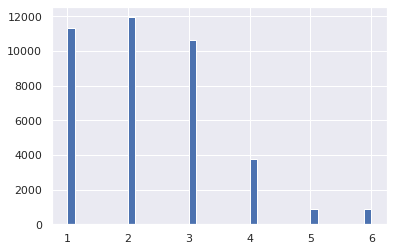

In [ ]:
train['Number_of_Doors'].hist(bins = 40)

In [ ]:
features.shape

(49999, 13)

In [ ]:
features.isnull().sum()

Property_Type              649
Property_Area                0
Number_of_Windows         2099
Number_of_Doors              0
Furnishing                1299
Frequency_of_Powercuts    1749
Power_Backup              1049
Water_Supply               449
Traffic_Density_Score        0
Crime_Rate                 999
Dust_and_Noise            1549
Air_Quality_Index            0
Neighborhood_Review          0
dtype: int64

In [ ]:
features["Frequency_of_Powercuts"] = features["Frequency_of_Powercuts"].ffill(axis = 0)
features["Frequency_of_Powercuts"] = features["Frequency_of_Powercuts"].bfill(axis = 0)
features["Property_Type"] = features["Property_Type"].ffill(axis = 0)
features["Property_Type"] = features["Property_Type"].bfill(axis = 0)
features["Number_of_Windows"] = features["Number_of_Windows"].ffill(axis = 0)
features["Number_of_Windows"] = features["Number_of_Windows"].bfill(axis = 0)
features["Furnishing"] = features["Furnishing"].ffill(axis = 0)
features["Furnishing"] = features["Furnishing"].bfill(axis = 0)
features["Power_Backup"] = features["Power_Backup"].ffill(axis = 0)
features["Power_Backup"] = features["Power_Backup"].bfill(axis = 0)
features["Water_Supply"] = features["Water_Supply"].ffill(axis = 0)
features["Water_Supply"] = features["Water_Supply"].bfill(axis = 0)
features["Dust_and_Noise"] = features["Dust_and_Noise"].ffill(axis = 0)
features["Dust_and_Noise"] = features["Dust_and_Noise"].bfill(axis = 0)
features["Crime_Rate"] = features["Crime_Rate"].ffill(axis = 0)
features["Crime_Rate"] = features["Crime_Rate"].bfill(axis = 0)

In [ ]:
features.isnull().sum()

Property_Type             0
Property_Area             0
Number_of_Windows         0
Number_of_Doors           0
Furnishing                0
Frequency_of_Powercuts    0
Power_Backup              0
Water_Supply              0
Traffic_Density_Score     0
Crime_Rate                0
Dust_and_Noise            0
Air_Quality_Index         0
Neighborhood_Review       0
dtype: int64

In [ ]:
train_features.shape

(39499, 13)

In [ ]:
test_features.isnull().sum()

Property_Type               0
Property_Area               0
Number_of_Windows         445
Number_of_Doors             0
Furnishing                257
Frequency_of_Powercuts    366
Power_Backup                0
Water_Supply                0
Traffic_Density_Score       0
Crime_Rate                212
Dust_and_Noise            330
Air_Quality_Index           0
Neighborhood_Review         0
dtype: int64

In [ ]:
import seaborn as sns
%matplotlib inline

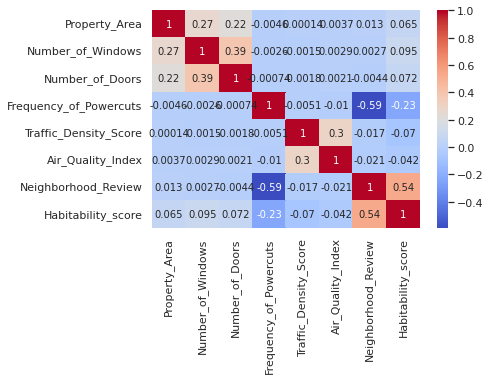

In [ ]:
sns.heatmap(train.corr(),cmap='coolwarm',annot=True)

In [ ]:
sns.set(rc = {'figure.figsize':(15,8)})

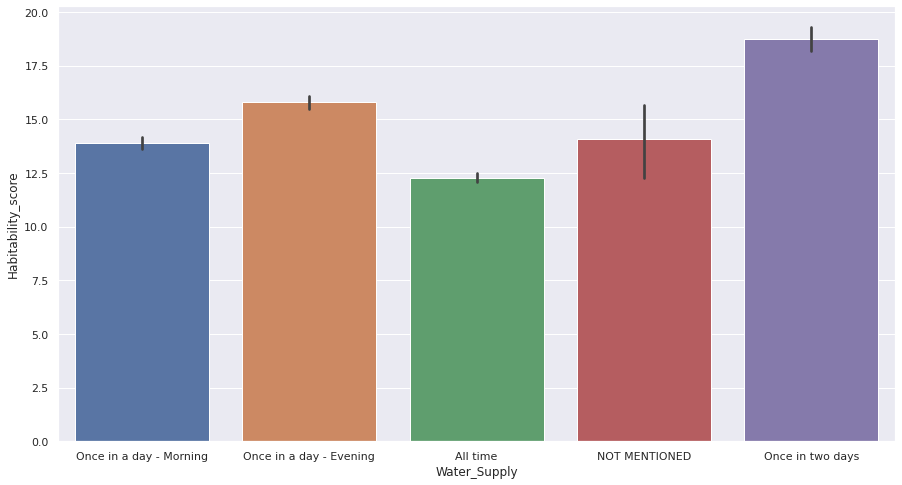

In [ ]:
sns.barplot(x='Water_Supply',y='Habitability_score',data=train,estimator=np.std)


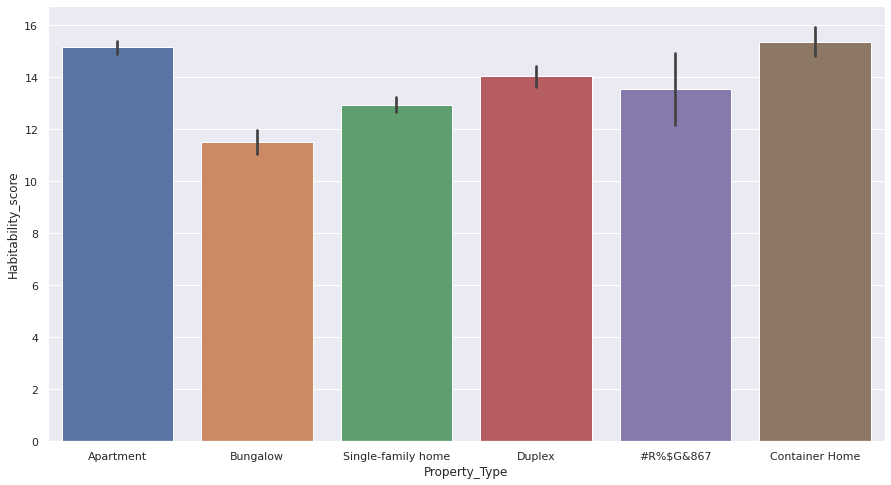

In [ ]:
sns.barplot(x='Property_Type',y='Habitability_score',data=train,estimator=np.std)


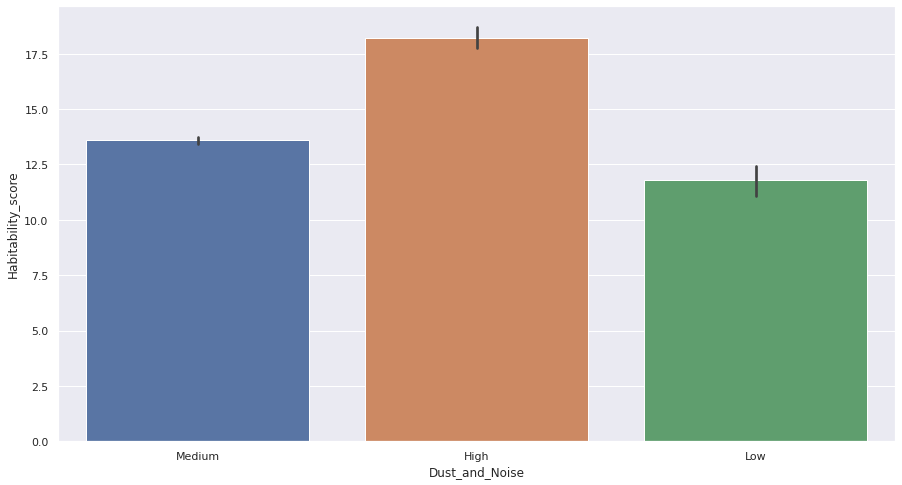

In [ ]:
sns.barplot(x='Dust_and_Noise',y='Habitability_score',data=train,estimator=np.std)


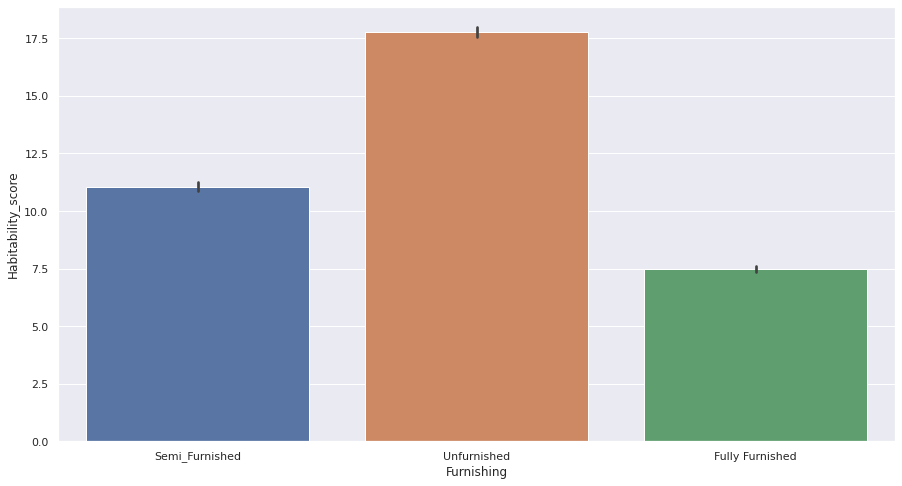

In [ ]:
sns.barplot(x='Furnishing',y='Habitability_score',data=train,estimator=np.std)


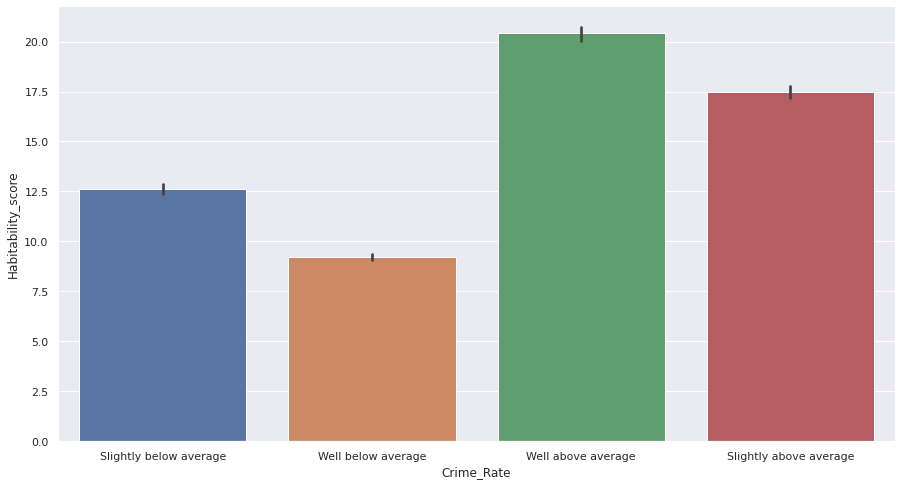

In [ ]:
sns.barplot(x='Crime_Rate',y='Habitability_score',data=train,estimator=np.std)

In [ ]:
features.isnull().sum()

Property_Type             0
Property_Area             0
Number_of_Windows         0
Number_of_Doors           0
Furnishing                0
Frequency_of_Powercuts    0
Power_Backup              0
Water_Supply              0
Traffic_Density_Score     0
Crime_Rate                0
Dust_and_Noise            0
Air_Quality_Index         0
Neighborhood_Review       0
dtype: int64

In [ ]:
import sklearn as sk


In [ ]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression

In [ ]:
features.shape

(49999, 13)

In [ ]:
y=train['Habitability_score']
y

0        164561.856734
1        159146.588199
2        160454.445909
3         12954.332928
4        369872.350088
             ...      
39494    174956.400100
39495    226841.698098
39496    240446.338469
39497    160040.658234
39498    257238.555738
Name: Habitability_score, Length: 39499, dtype: float64

In [ ]:
X = features.iloc[:len(y), :]
X_sub = features.iloc[len(y):, :]
X.shape, y.shape, X_sub.shape

((39499, 13), (39499,), (10500, 13))

Modelling


In [ ]:
def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())

In [ ]:
from sklearn.ensemble import RandomForestRegressor
 
 # create regressor object
regressor = RandomForestRegressor(n_estimators = 600, random_state = 0)
regressor.fit(X, y) 
print(rmse(y, regressor.predict(X)))

16402.23964978187


In [ ]:
test1 = pd.read_csv('/content/drive/MyDrive/HAcker/test.csv')

In [ ]:
z1= regressor.predict(X_sub)

df3 = pd.DataFrame()
df3['Property_ID']=test1['Property_ID']
df3['Habitability_score'] = z1.tolist()
df3.to_csv('submission23.csv',index=False)

In [ ]:
from sklearn.model_selection import KFold
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV
from sklearn.linear_model import ElasticNetCV
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.datasets import make_regression
from sklearn.ensemble import GradientBoostingRegressor

In [ ]:
kfolds = KFold(n_splits=10, shuffle=True, random_state=42)

def rmsle(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

def cv_rmse(model, X=X):
    rmse = np.sqrt(-cross_val_score(model, X, y, scoring="neg_mean_squared_error", cv=kfolds))
    return (rmse)

In [ ]:
alphas_alt = [14.5, 14.6, 14.7, 14.8, 14.9, 15, 15.1, 15.2, 15.3, 15.4, 15.5]
alphas2 = [5e-05, 0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007, 0.0008]
e_alphas = [0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007]
e_l1ratio = [0.8, 0.85, 0.9, 0.95, 0.99, 1]

In [ ]:
ridge = make_pipeline(RobustScaler(), RidgeCV(alphas=alphas_alt, cv=kfolds))
lasso = make_pipeline(RobustScaler(), LassoCV(max_iter=1e7, alphas=alphas2, random_state=42, cv=kfolds))
elasticnet = make_pipeline(RobustScaler(), ElasticNetCV(max_iter=1e7, alphas=e_alphas, cv=kfolds, l1_ratio=e_l1ratio))                                
svr = make_pipeline(RobustScaler(), SVR(C= 20, epsilon= 0.008, gamma=0.0003,))

In [ ]:
gbr = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05, max_depth=4, max_features='sqrt', min_samples_leaf=15, min_samples_split=10, loss='huber', random_state =42)  

In [ ]:
import lightgbm as lgb
import xgboost as xgb

In [ ]:
lightgbm = lgb.LGBMRegressor(objective='regression', 
                                       num_leaves=4,
                                       learning_rate=0.01, 
                                       n_estimators=5000,
                                       max_bin=200, 
                                       bagging_fraction=0.75,
                                       bagging_freq=5, 
                                       bagging_seed=7,
                                       feature_fraction=0.2,
                                       feature_fraction_seed=7,
                                       verbose=-1,
                                       )

In [ ]:
xgboost = xgb.XGBRegressor(learning_rate=0.01,n_estimators=3460,
                                     max_depth=3, min_child_weight=0,
                                     gamma=0, subsample=0.7,
                                     colsample_bytree=0.7,
                                     objective='reg:linear', nthread=-1,
                                     scale_pos_weight=1, seed=27,
                                     reg_alpha=0.00006)

Stacking


In [ ]:
from mlxtend.regressor import StackingCVRegressor

In [ ]:
stack_gen = StackingCVRegressor(regressors=(ridge, lasso, elasticnet, gbr, xgboost, lightgbm),
                                meta_regressor=xgboost,
                                use_features_in_secondary=True)

In [ ]:
from sklearn.model_selection import cross_val_score
import datetime
now = datetime.datetime.now

In [ ]:
 #Using various prediction models that we just created 


score = cv_rmse(ridge , X)
score = cv_rmse(lasso , X)
print("LASSO: {:.4f} ({:.4f})\n".format(score.mean(), score.std()) )

score = cv_rmse(elasticnet)
print("elastic net: {:.4f} ({:.4f})\n".format(score.mean(), score.std()) )

score = cv_rmse(svr)
print("SVR: {:.4f} ({:.4f})\n".format(score.mean(), score.std()) )

score = cv_rmse(lightgbm)
print("lightgbm: {:.4f} ({:.4f})\n".format(score.mean(), score.std()) )

score = cv_rmse(gbr)
print("gbr: {:.4f} ({:.4f})\n".format(score.mean(), score.std()) )

score = cv_rmse(xgboost)
print("xgboost: {:.4f} ({:.4f})\n".format(score.mean(), score.std()) )

LASSO: 9.2703 (0.1330)

elastic net: 9.2703 (0.1331)

SVR: 9.7710 (0.2220)

lightgbm: 7.9228 (0.1023)

gbr: 6.5819 (0.1200)

[12:07:06] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:08:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:08:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:09:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:10:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:11:46] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:12:41] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:

In [ ]:
print('START Fit')

print('stack_gen')
stack_gen_model = stack_gen.fit(np.array(X), np.array(y))

print('elasticnet')
elastic_model_full_data = elasticnet.fit(X, y)

print('Lasso')
lasso_model_full_data = lasso.fit(X, y)

print('Ridge')
ridge_model_full_data = ridge.fit(X, y)

print('Svr')
svr_model_full_data = svr.fit(X, y)

print('GradientBoosting')
gbr_model_full_data = gbr.fit(X, y)

print('xgboost')
xgb_model_full_data = xgboost.fit(X, y)

print('lightgbm')
lgb_model_full_data = lightgbm.fit(X, y)

START Fit
stack_gen
[12:25:09] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:25:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:26:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:27:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:28:31] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:29:55] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:33:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
elasticnet
Lasso
Ridge
Svr
GradientBoosting
xgboost
[12:38:17] WARNING: /workspace/src/obje

In [ ]:
def blend_models_predict(X):
    return ((0.1 * elastic_model_full_data.predict(X)) + \
            (0.05 * lasso_model_full_data.predict(X)) + \
            (0.05 * ridge_model_full_data.predict(X)) + \
            (0.1 * svr_model_full_data.predict(X)) + \
            (0.1 * gbr_model_full_data.predict(X)) + \
            (0.15 * xgb_model_full_data.predict(X)) + \
            (0.15 * lgb_model_full_data.predict(X)) + \
            (0.3 * stack_gen_model.predict(np.array(X))))

In [ ]:
print('RMSE score on blended train data:')
print(rmse(y, blend_models_predict(X)))

RMSE score on blended train data:
6.66047970217106


In [ ]:
print('Predict submission')
submission = pd.read_csv("/content/drive/MyDrive/HAcker/sample_submission.csv")
bv = blend_models_predict(X_sub)

Predict submission


In [ ]:
bv


array([34.36109371, 77.40442289, 65.93598518, ..., 77.13884177,
       74.90234188, 78.28390482])

In [ ]:
test1=pd.read_csv('/content/drive/MyDrive/HAcker/test.csv')
df1 = pd.DataFrame()
df1['Property_ID']=test1['Property_ID']
df1['Habitability_score'] = bv.tolist()

In [ ]:
df1.to_csv('submission.csv',index=False)


In [ ]:
print(rmse(y, gbr_model_full_data.predict(X)))

5.922300762159022


In [ ]:
z= gbr_model_full_data.predict(X_sub)

df2 = pd.DataFrame()
df2['Property_ID']=test1['Property_ID']
df2['Habitability_score'] = z.tolist()
df1.to_csv('submission2.csv',index=False)